# Study on (tailcut) cleaning optimisation

Notes:
- This benchmark might not be optimal
- It could use the prepared file from `Preparation/integration_prep.ipynb`

The idea here is to define a benchmark to optimise cleaning independently of any reconstruction that would come **after**.    
This to avoid optimising the cleaning as a function of the whole reconstruction as:   
- it can be tedious (you have to loop over the whole reconstruction)    
- optimising cleaning before optimising the later part of the reconstruction might end up in reaching a cleaning well adapted to the reconstruction method chosen a priori but not good in absolute. (then a different/better reconstruction might end-up showing worst results)


This benchmark uses the the ground thruth image in photo-electron from MC simulations by computing the distance between the cleaned image and the ground truth as a function of cleaning method/parameters and finding the minimum of this distance (average on many events).

This also allow to study the cleaning as a function of event info (such as energy, signal amplitude... )

Of course, this supposes that the calibration has been previously optimised.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
from ctapipe.io import event_source
from ctapipe.utils import datasets
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import poisson
import os
from ctapipe.utils import get_dataset
import copy
import astropy.units as u
%matplotlib inline

In [3]:
def apply_cleaning(calibrated_event, cleaning, **cleaning_params):
    """
    Apply a cleaning method to a calibrated event
    """
    
    chan = 0
    
    for tel_id in calibrated_event.r0.tels_with_data:
        camera = calibrated_event.inst.subarray.tel[tel_id].camera
        image = calibrated_event.dl1.tel[tel_id].image[chan]

        # Apply image cleaning
        cleanmask = cleaning(camera, image,
                                   **cleaning_params
                                   )
        
        calibrated_event.dl1.tel[tel_id].cleaned = copy.copy(calibrated_event.dl1.tel[tel_id].image[0])
        calibrated_event.dl1.tel[tel_id].cleaned[~cleanmask] = 0
        

In [4]:
def tailcut_cleaning_accuracy(calibrated_event, picture_threshold, boundary_threshold, cam_id):
    """
    Compute the accuracy of the tailcut cleaning as the norm of the distance between cleaned image
    and ground truth image.
    Runs on all telescopes with data.
    note: could be made more general for any cleaning?
    """
    
    diff = 0
    chan = 0
    
    tailcut_params = {'picture_thresh':picture_threshold,
                  'boundary_thresh':boundary_threshold,
                  'keep_isolated_pixels':False,
                  'min_number_picture_neighbors':1,
                 }
    
            
    for tel_id in calibrated_event.r0.tels_with_data:
        camera = calibrated_event.inst.subarray.tel[tel_id].camera
        if camera.cam_id == cam_id:
            signals = calibrated_event.dl1.tel[tel_id].image[chan]

            apply_cleaning(calibrated_event, tailcuts_clean, **tailcut_params)

            cleaned_image = calibrated_event.dl1.tel[tel_id].cleaned
            true_image = calibrated_event.mc.tel[tel_id].photo_electron_image 

            diff += np.linalg.norm(cleaned_image - true_image)
    
    return diff

In [6]:
def tailcut_cleaning_analyse(source, cam_id, picture_threshold=[2, 10, 5], min_boundary_threshold=0):
    """
    source: event_source object
    picture_threshold: list of [min, max, number of steps]
    """
    ptmin, ptmax, ptnumber = picture_threshold
    pt = np.linspace(ptmin, ptmax, ptnumber)
    
    picture_threshold = np.empty((ptnumber,ptnumber))
    boundary_threshold = np.empty((ptnumber,ptnumber))
    for i in range(ptnumber):
        picture_threshold[i] = pt
        boundary_threshold.T[i] = np.linspace(min_boundary_threshold, pt[i], ptnumber)
        
    all_diff = []
    event_energy = []
    event_dl1_amplitude = []
    event_multiplicity = []
    
    for event in source:
        cal.calibrate(event)
        diff = np.zeros((ptnumber,ptnumber))
        event_energy.append(event.mc.energy.to(u.TeV).value)
        event_multiplicity.append(len(event.r0.tels_with_data))
        for i in range(ptnumber):
            for j in range(ptnumber):
                pt = picture_threshold[i, j]
                bt = boundary_threshold[i, j]
                d = tailcut_cleaning_accuracy(event, pt, bt, cam_id=cam_id)
                diff[i,j]+=d
        all_diff.append(diff)
        
        amp = 0
        for tel_id in event.r0.tels_with_data:
            amp += event.dl1.tel[tel_id].image[0].sum()
        event_dl1_amplitude.append(amp)
        
    all_diff = np.array(all_diff)
    
    event_info = {'event_energy': np.array(event_energy) * u.TeV, 
                  'event_multiplicity': np.array(event_multiplicity),
                  'event_dl1_amplitude': np.array(event_dl1_amplitude)}
    
    return np.array([picture_threshold, boundary_threshold]), all_diff, event_info

In [7]:
def find_best_threshold(thresholds, all_diff):
    index = np.unravel_index(all_diff.sum(axis=0).argmin(), all_diff.sum(axis=0).shape)
    return thresholds[0][index], thresholds[1][index]

In [8]:
def plot_cleaning_analysis(thresholds, all_diff, ax=None, **kwargs):
    
    ax = plt.gca() if ax is None else ax
    
    x = thresholds[0].ravel()
    y = thresholds[1].ravel()
    z = all_diff.sum(axis=0).ravel()
    im = ax.tricontourf(x,y,z, 20)
    ax.set_xlabel('picture threshold')
    ax.set_ylabel('boundary threshold')
    plt.colorbar(im)
    # ax.axis('equal')
    print("Best thresholds = ", find_best_threshold(thresholds, all_diff))
    return ax

In [9]:
def analyse_all_cameras(filename, 
                        cal = CameraCalibrator(None, None, 
                                               r1_product='HESSIOR1Calibrator', 
                                               extractor_product='NeighbourPeakIntegrator'),
                       max_events = None,
                       **kwargs_tailcut_analysis):
    
    source = event_source(filename)
    
    source.max_events = max_events
    
    cam_dict = {}
    event = next(iter(source))
    for tel_id in event.inst.subarray.tel:
        cam_id = event.inst.subarray.tel[tel_id].camera.cam_id
        if not cam_id in cam_dict:
            cam_dict[cam_id] = []

    for cam_id in cam_dict:     
        thresholds, all_diff, event_info = tailcut_cleaning_analyse(source, 
                                                                    cam_id,
                                                                    picture_threshold=[2, 20, 10],
                                                                    min_boundary_threshold=-10 )
        cam_dict[cam_id] = find_best_threshold(thresholds, all_diff)
        print("Best thresholds for camera {0} are: {1}".format(cam_id, find_best_threshold(thresholds, all_diff)))
            
    return cam_dict

In [1]:
input_dir = 'input_data'
gamma_diffuse = 'gamma_40deg_0deg_run102___cta-prod3-lapalma3-2147m-LaPalma_cone10.simtel.gz'

In [10]:
filename = input_dir + '/' + gamma_diffuse
source = event_source(input_url = filename)
source.max_events = 60

In [14]:
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')

In [15]:
event=next(iter(source))

## Visualise simple cleaning example

41


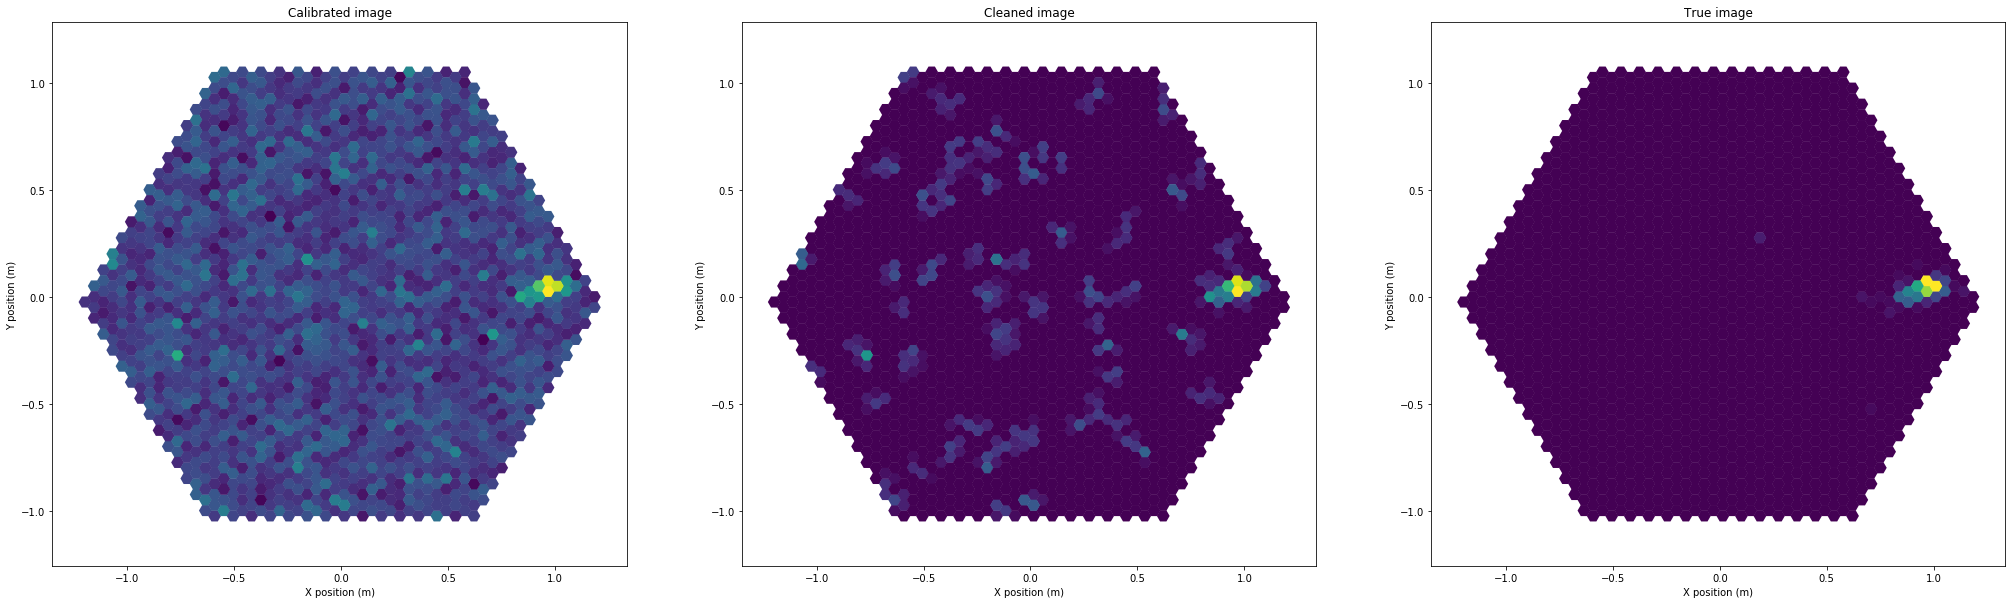

74


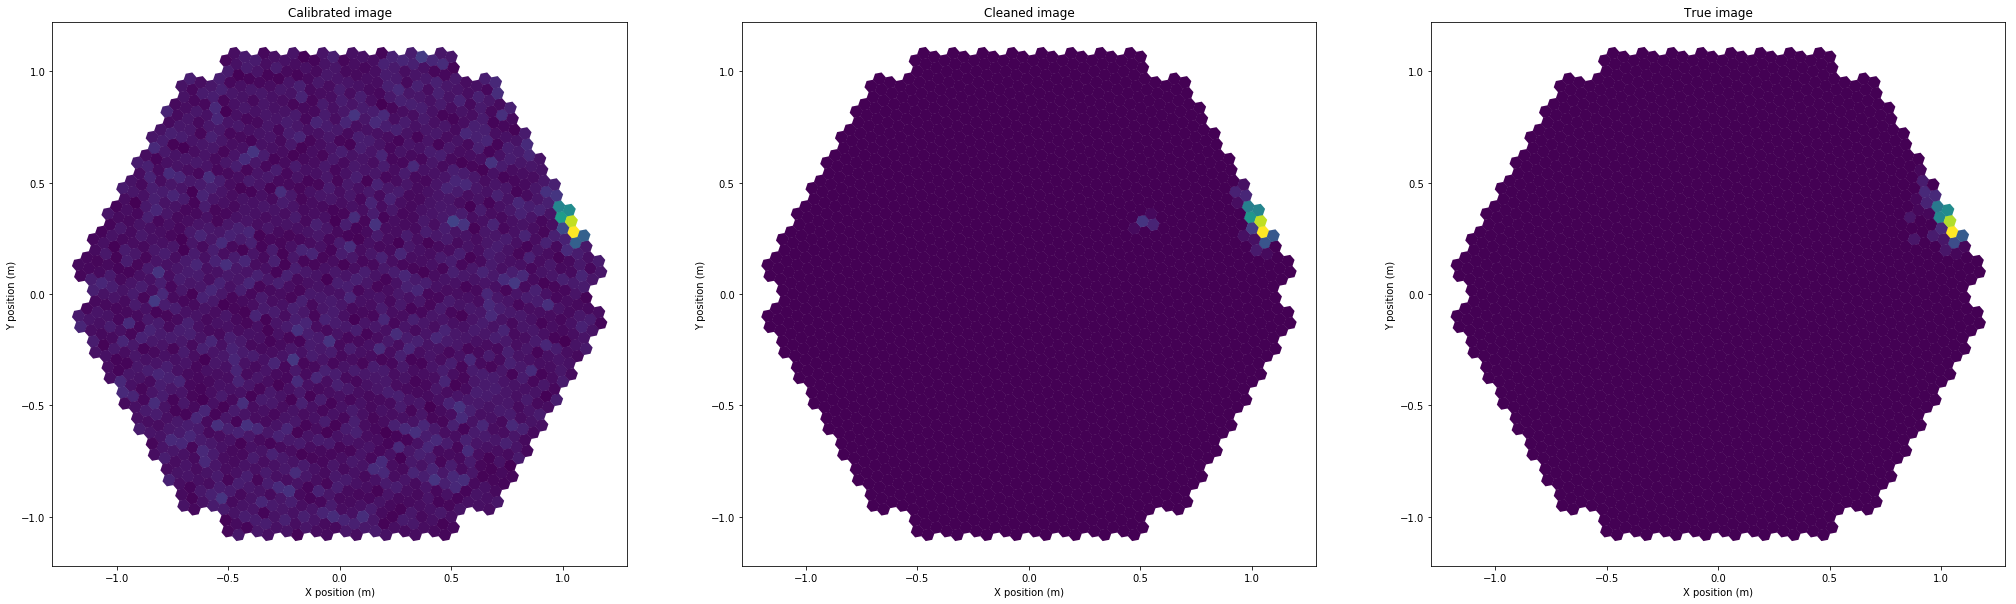

75


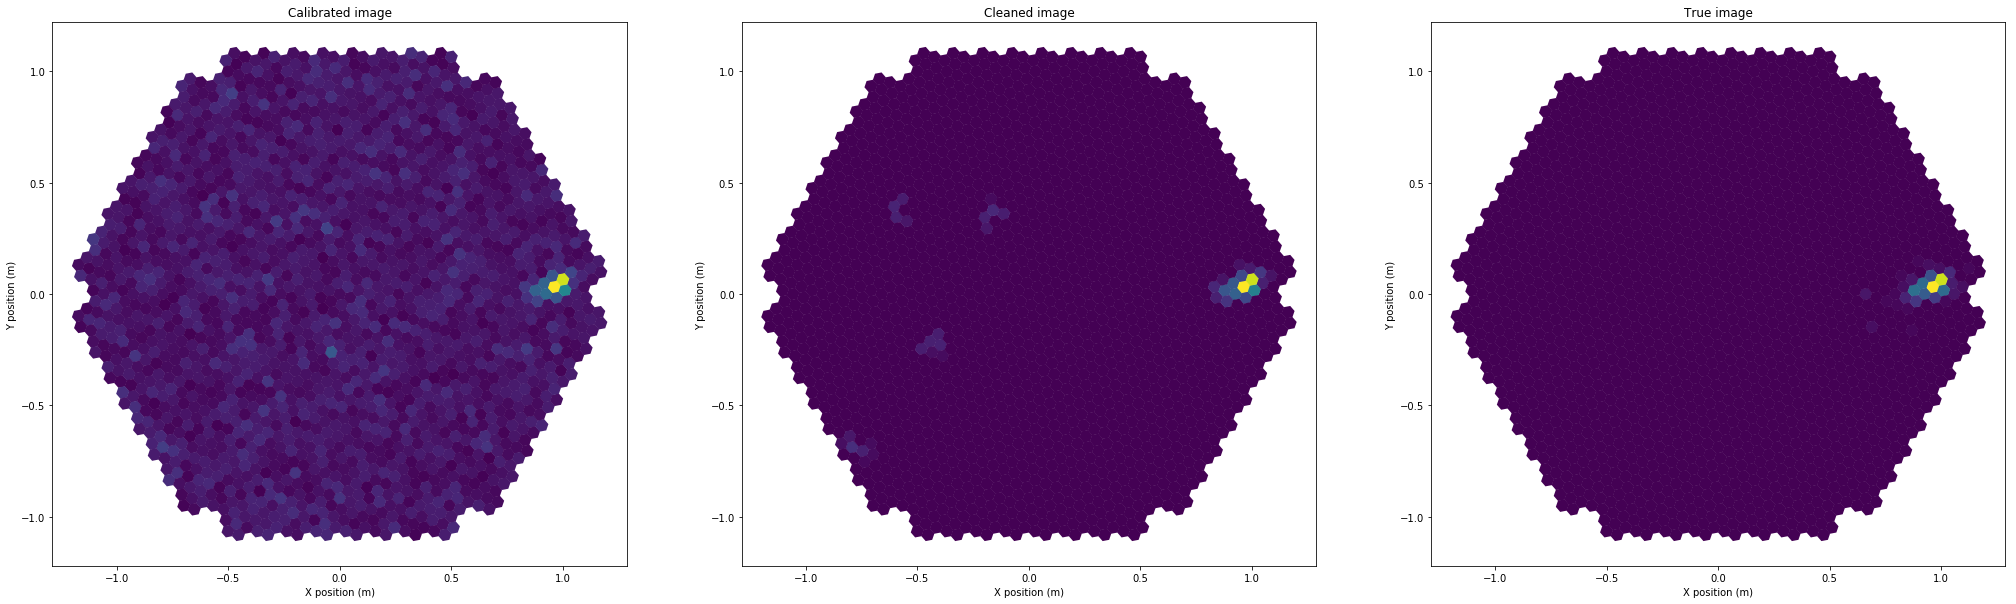

17


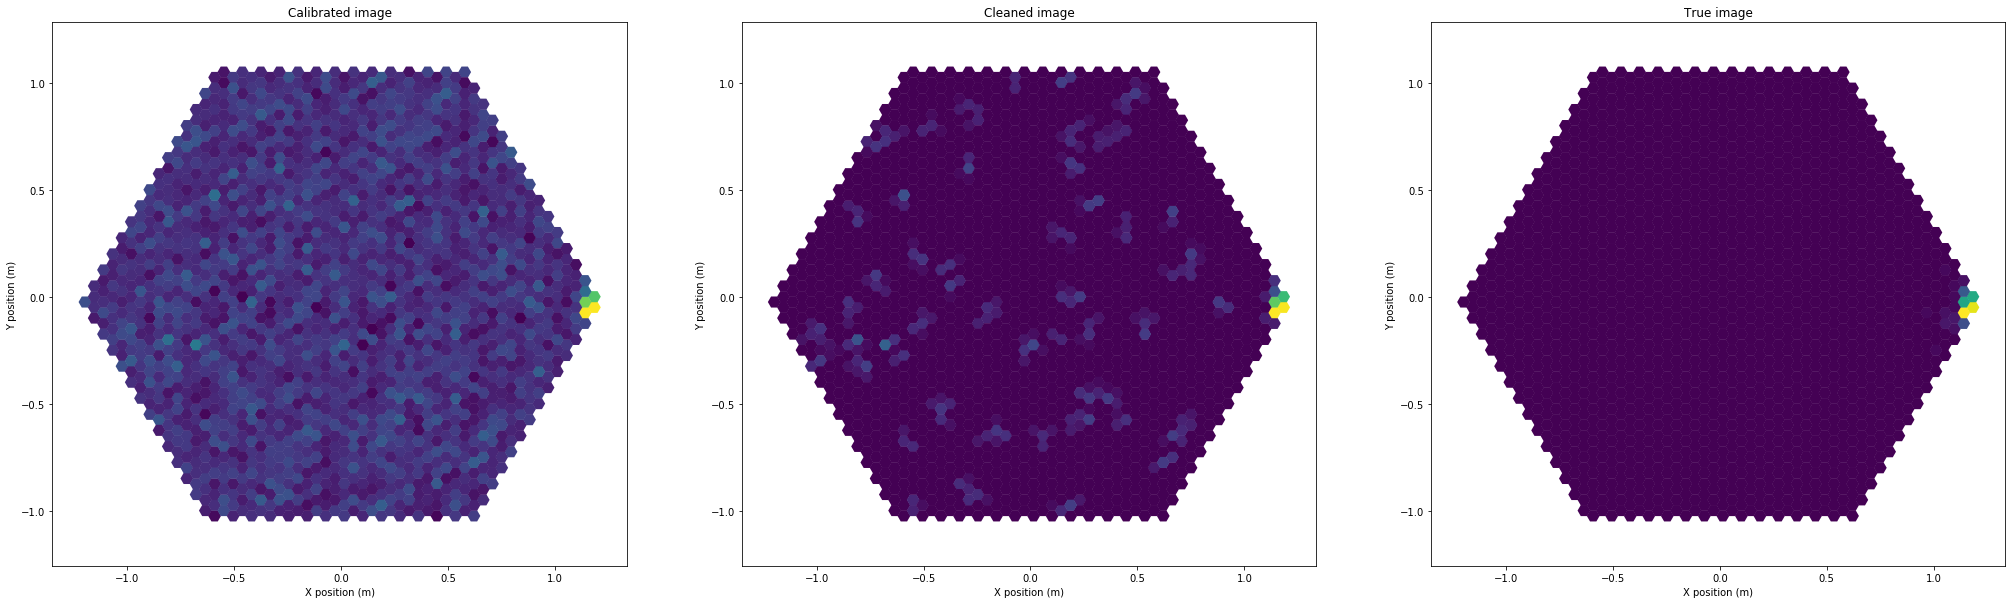

51


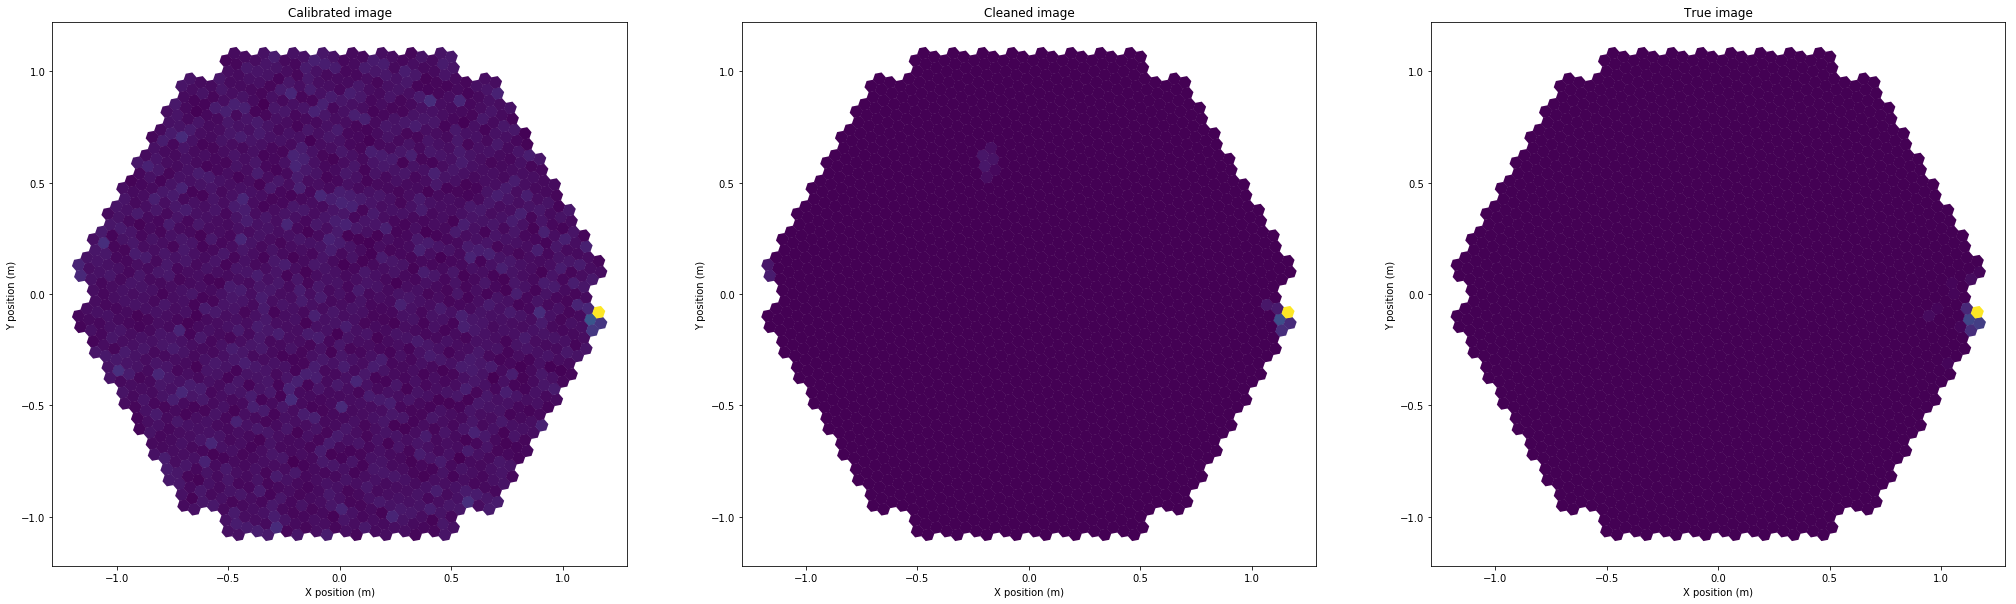

25


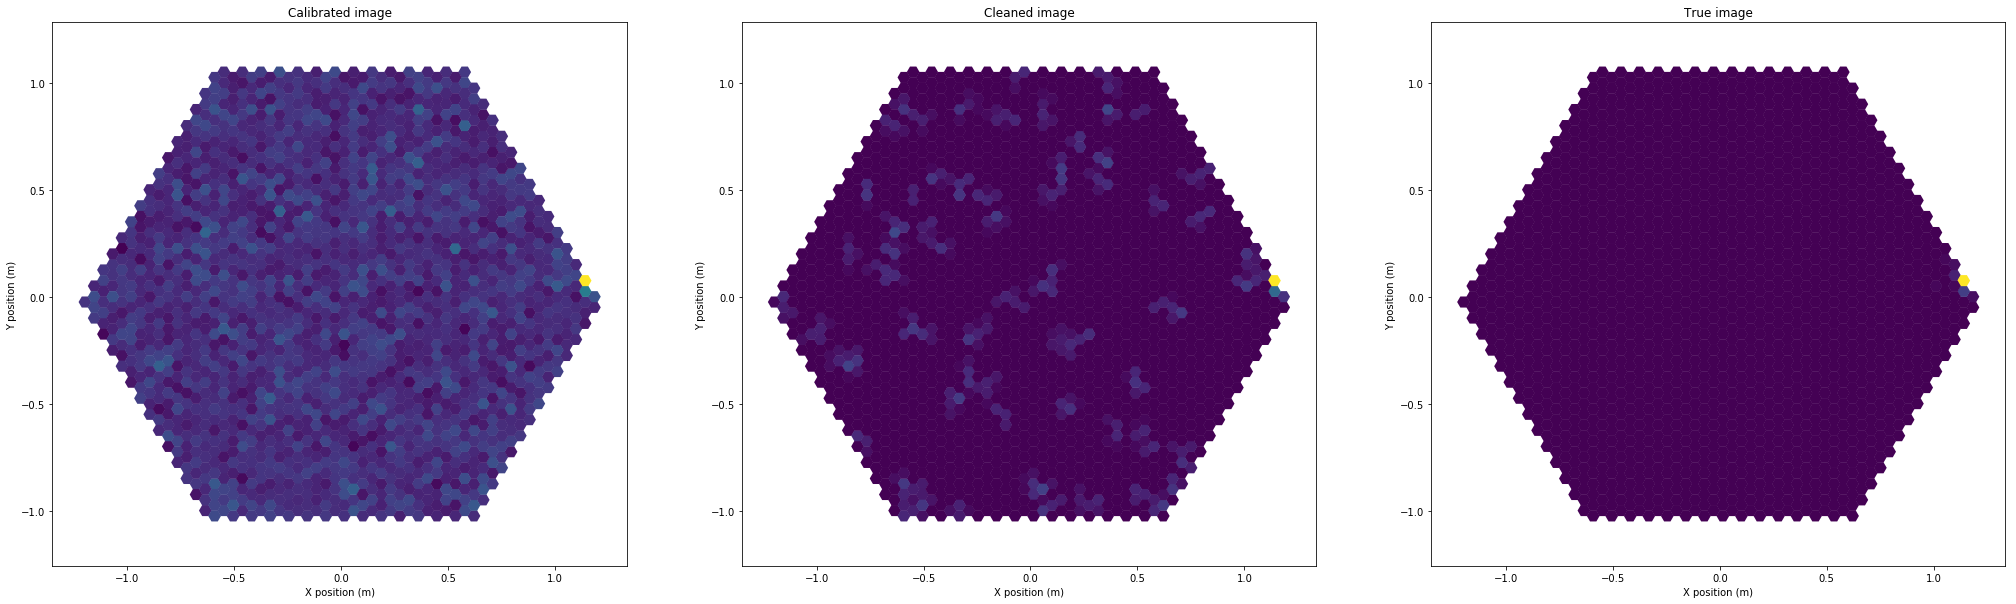

58


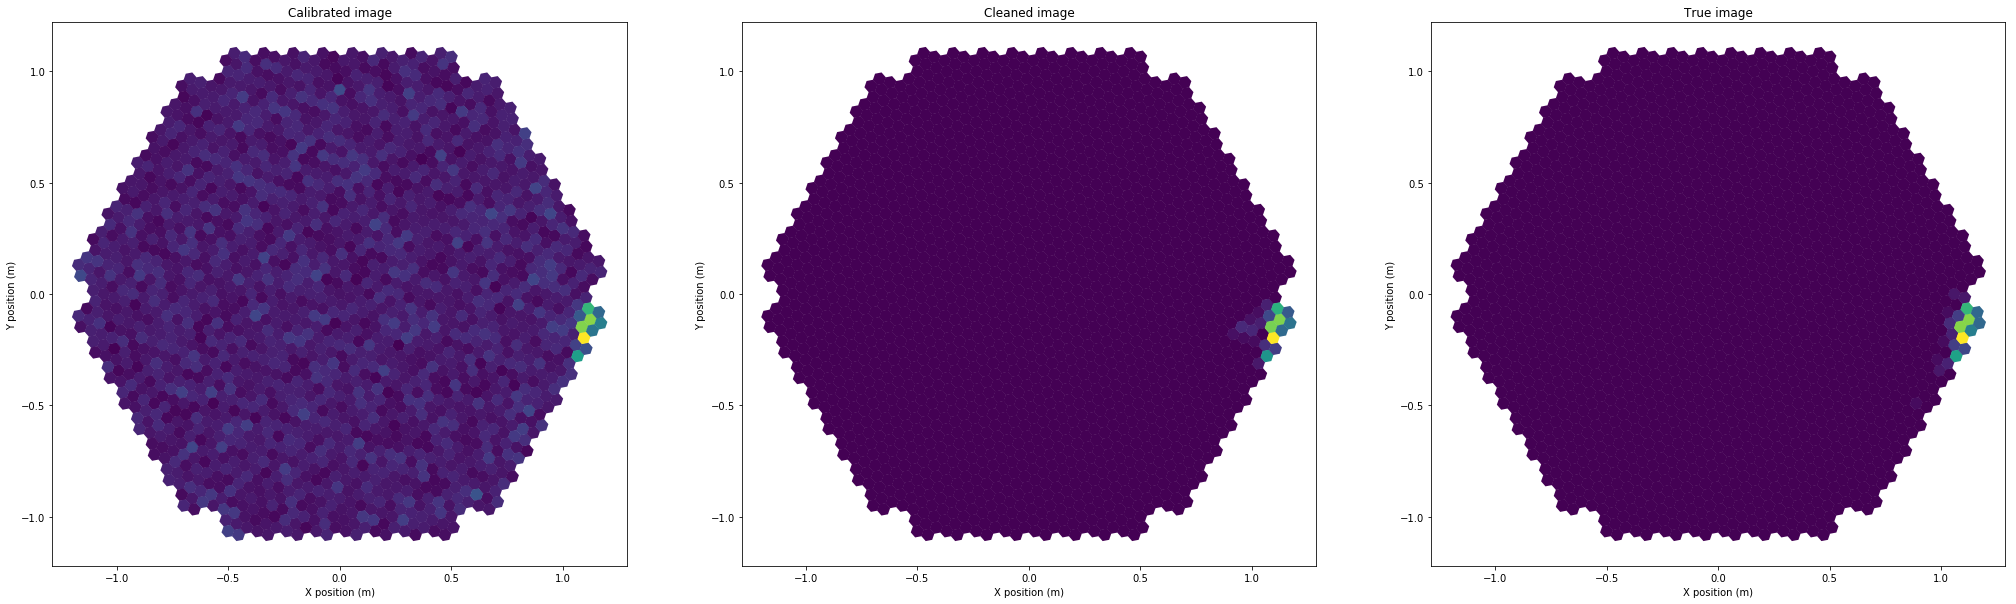

59


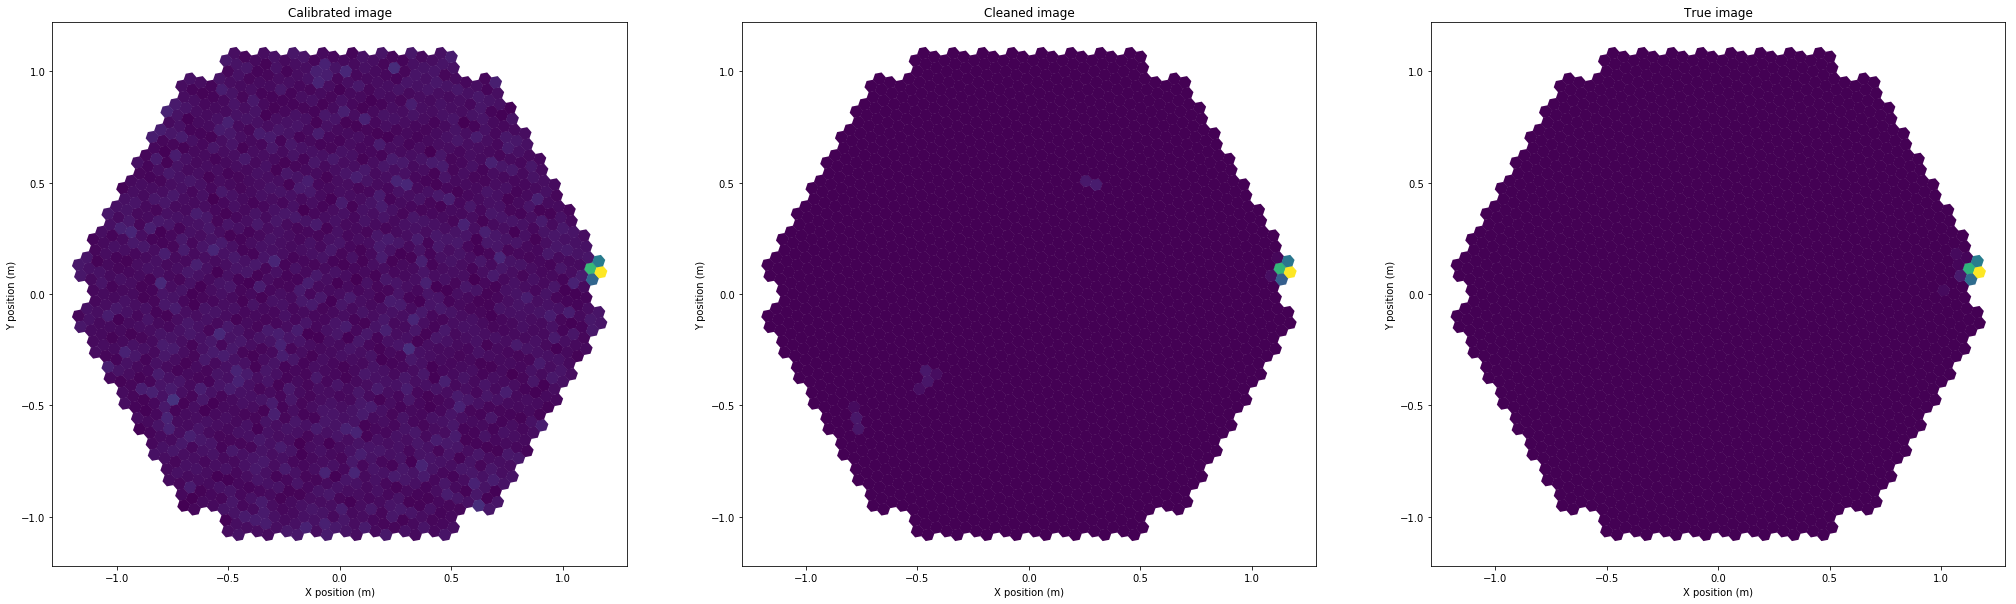

In [16]:
tailcut_params = {'picture_thresh':4,
                  'boundary_thresh':1,
                  'keep_isolated_pixels':False,
                  'min_number_picture_neighbors':1,
                 }
cal.calibrate(event)
apply_cleaning(event, tailcuts_clean, **tailcut_params)
for tel_id in event.r0.tels_with_data:
    fig, axes = plt.subplots(1, 3, figsize=(35,10))
    print(tel_id)
    CameraDisplay(event.inst.subarray.tel[tel_id].camera, event.dl1.tel[tel_id].image[0], ax=axes[0])
    axes[0].set_title("Calibrated image")
    CameraDisplay(event.inst.subarray.tel[tel_id].camera, event.dl1.tel[tel_id].cleaned, ax=axes[1])
    axes[1].set_title("Cleaned image")
    CameraDisplay(event.inst.subarray.tel[tel_id].camera, event.mc.tel[tel_id].photo_electron_image, ax=axes[2])
    axes[2].set_title("True image")
    plt.show()

In [17]:
tailcut_cleaning_accuracy(event, 8, 3, 'FlashCam')

81.80173776771503

# Run the analysis

In [18]:
thresholds, all_diff, event_info = \
tailcut_cleaning_analyse(source,
                         'LSTCam',
                         picture_threshold=[2, 20, 10],
                         min_boundary_threshold=-10 )

In [19]:
print(thresholds.shape, all_diff.shape)
print(event_info.keys())

(2, 10, 10) (60, 10, 10)
dict_keys(['event_energy', 'event_dl1_amplitude', 'event_multiplicity'])


## Visualise the result and finding the best tailcut thresholds

Best thresholds =  (6.0, 0.6666666666666661)


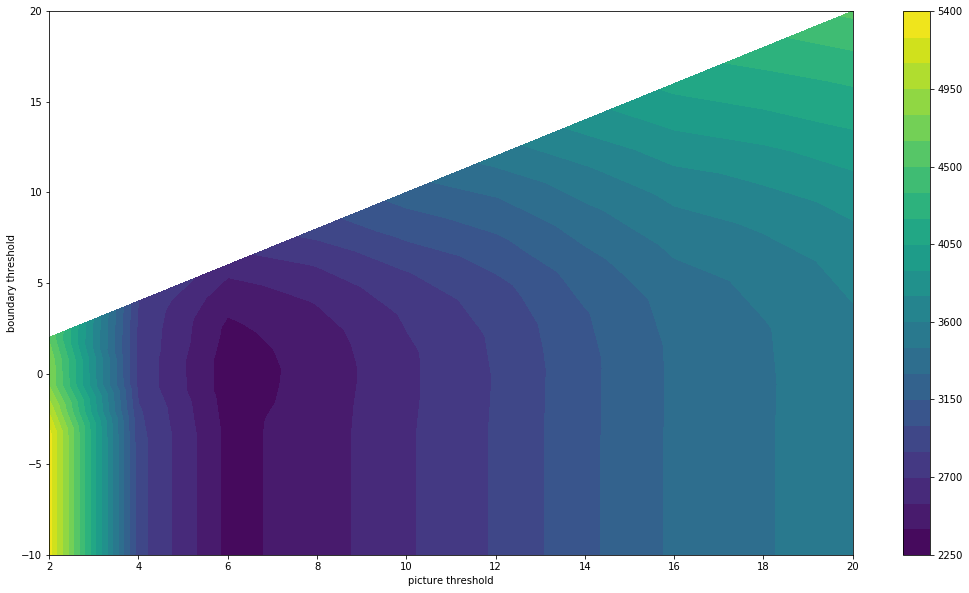

In [21]:
fig, ax = plt.subplots(figsize=(18,10))
ax = plot_cleaning_analysis(thresholds, all_diff, ax=ax)

## One can also make analysis as a function of event info

### By total event amplitude (in p.e.)

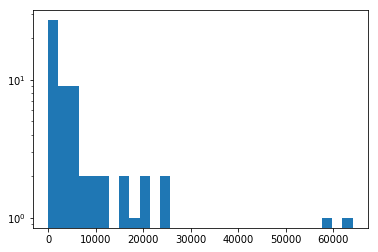

In [23]:
plt.hist(event_info['event_dl1_amplitude'], log=True, bins=30);

In [24]:
mask = event_info['event_dl1_amplitude'] > 2000

Best thresholds =  (6.0, 0.6666666666666661)


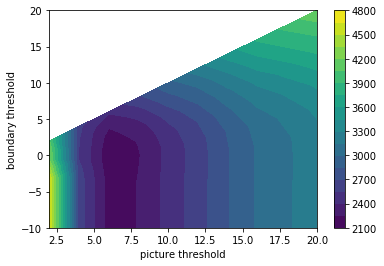

In [25]:
ax = plot_cleaning_analysis(thresholds, all_diff[mask])

#### Or by event energy

In [26]:
mask = event_info['event_energy'].value < 1

Best thresholds =  (6.0, 0.6666666666666661)


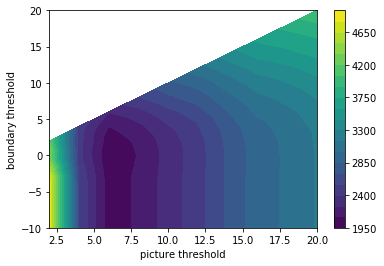

In [27]:
ax = plot_cleaning_analysis(thresholds, all_diff[mask])

# Finally one can make an analysis to find the best threshold for each camera type

In [28]:
best_thresh = analyse_all_cameras(filename, 
                                  max_events=30, 
                                  **{'picture_threshold': [2, 14, 10], 
                                     'min_boundary_threshold':-4})

Best thresholds for camera NectarCam are: (6.0, 0.6666666666666661)
Best thresholds for camera FlashCam are: (12.0, -0.22222222222222143)
Best thresholds for camera LSTCam are: (6.0, 0.6666666666666661)
Best thresholds for camera SCTCam are: (2.0, -10.0)
